# Are the pulses valid in the RWA? 

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
from notebook_utils import get_stage2_table, get_RWA_table, compare_RWA_prop
import QDYN

## Reminder: RWA in a multilevel system

In [6]:
import sympy as sp
from sympy import exp, pi, I
from sympy import init_printing
init_printing() 

In [7]:
wc = sp.Symbol(r'\omega_C', real=True)
wd = sp.Symbol(r'\omega_d', real=True)
t = sp.Symbol('t', real=True)
eps = sp.Symbol(r'\epsilon', real=True)

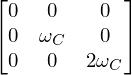

In [8]:
H0 = sp.eye(3); H0[0,0] = 0; H0[1,1] = wc; H0[2,2] = 2*wc; H0

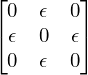

In [9]:
H1 = sp.zeros(3,3); H1[0,1] = eps; H1[1,2] = eps; H1 += H1.H; H1

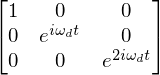

In [10]:
U = sp.eye(3); U[1,1] = exp(I*wd*t); U[2,2] = sp.exp(2*I*wd*t); U

In [11]:
def to_RWA(H, U):
    return I * U.diff(t) * U.H + U * H * U.H

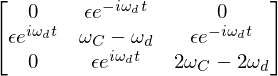

In [12]:
to_RWA(H0+H1, U)

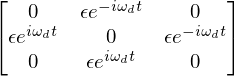

In [13]:
U * H1 * U.H

## Repropagating the stage2 results in the RWA

Make sure to have an iPython cluster running!

In [ ]:
from IPython.parallel import Client
rc = Client()
lview = rc.load_balanced_view()

In [6]:
stage2_table = get_stage2_table('./runs_200_LAB/')

In [7]:
def worker(rf):
    from notebook_utils import prop_RWA
    from os.path import join, isfile
    config_file = join(rf, 'config')
    pulse_json = join(rf, 'pulse_opt.json')
    if isfile(config_file) and isfile(pulse_json):
        prop_RWA(config_file, pulse_json, rf)

In [8]:
jobs = lview.map(worker, stage2_table.index)

In [38]:
print "progress: %.1f%% (%d/%d)" % (100.0*float(jobs.progress)/len(jobs), jobs.progress, len(jobs))

progress: 100.0% (1553/1553)


In [39]:
jobs.wait()

In [5]:
RWA_table = get_RWA_table('./runs_200_LAB/')

./runs_200_LAB/w2_7500MHz_wc_7600MHz/stage2/SQ_1freq_center/U_RWA.dat is invalid
./runs_200_LAB/w2_7500MHz_wc_8600MHz/stage2/SQ_1freq_random/U_RWA.dat is invalid


In [13]:
combined_table = pd.concat([stage2_table, RWA_table], axis=1);
combined_table['Delta loss'] = np.abs(combined_table['avg loss'] - combined_table['loss (RWA)'])
combined_table['Delta C']   = np.abs(combined_table['C'] - combined_table['C (RWA)'])
#combined_table = combined_table[combined_table['w2 [GHz]'] != combined_table['w1 [GHz]']]
#combined_table = combined_table[(combined_table['category']=='1freq_random') | (combined_table['category']=='1freq_center')]
#combined_table = combined_table[(combined_table['category']=='2freq_random') | (combined_table['category']=='2freq_resonant')]
combined_table = combined_table[(combined_table['category'] !='5freq_random') ] # 5freq was buggy in this run
combined_table = combined_table[(combined_table['avg loss'] < 0.1) ]
combined_table.drop(['w1 [GHz]', 'w2 [GHz]', 'wc [GHz]', 'J_PE', 'J_SQ', 'target'], axis=1, inplace=True)
combined_table.sort('Delta C', inplace=True, ascending=False)
pd.options.display.max_colwidth = 100
with open('combined_rwa_table.dat', 'w') as out_fh:
     out_fh.write(combined_table.to_string())

See results in `combined_rwa_table.dat`. Propagations show pretty good agreement, except for some buggy runs, where the sampling rate was not good enough.